# HW6 2021300003004 张天骏

## 理论计算过程

递归形式：
$$\begin{align}
&v(k_{t},z_{t})=  \underset{ c_{t},k_{t+1} }{ \max } \left\{  \ln c_{t}+\beta \mathbb{E}\underset{ z_{t+1|z_{t}} }{ \sum } v(k_{t+1},z_{t+1})\pi(z_{t+1}|z_{t}) \right\} \\
 & s.t. \quad c_{t}+k_{t+1}=z_{t}k_{t}^\alpha+(1-\delta)k_{t}
\end{align}
$$

---

FOC: $\frac{1}{c_{t}}=\beta \mathbb{E}[v_{k}(k_{t+1},z_{t+1})|z_{t}]$

Envelope:$v_{k}(k_{t},z_{t})=\frac{1}{c_{t}}(z_{t}\alpha k_{t}^{\alpha-1}+(1-\delta))$

对应的EE：$\frac{1}{c_{t}}=\beta \mathbb{E}\left[ \frac{1}{c_{t+1}}(z_{t+1}\alpha k_{k+1}^{\alpha-1}+1-\delta)|z_{t} \right]$

改写一下就是：$\frac{c_{t+1}}{c_{t}}=\beta \mathbb{E}\left[ z_{t+1}\alpha k_{k+1}^{\alpha-1}+1-\delta|z_{t} \right]$

由此可以求出稳态：即$LHS=1$时：$z^*$代表不变分布
$$
k^*=\left( \frac{1-\beta(1-\delta)}{\alpha \beta \mathbb{E}(z^*)} \right)^{\frac{1}{\alpha-1}}
$$




对于题目的马氏过程：
$$\mathbf{P}=\begin{pmatrix}0.9727&0.0273& & & \\0.0041&0.9806&0.0153& & \\&0.0082&0.9836&0.0082& \\&&0.0153&0.9806&0.0041& \\&&&0.0273&0.9727 \end{pmatrix}$$

可以根据方程$\mathbf{z}=\mathbf{z P}$求出不变分布：
$\mathbf{z^*}=(0.036,0.240,0.448,0.240,0.036)$

从而可以求出:$\mathbb{E}(z^*)=1$ (因为分布是对称的)


假设$\delta=0.1,\alpha=\frac{1}{3},\beta=0.95$，现在我们得到了稳态$k^*=3.227$

## 数值迭代求解

按照题目要求，选取$k^*$左右30%的区间均匀取点2500个，设置精度为1e-7

In [1]:
# import

import timeit
import numpy as np
from numba import njit
import numba 
import matplotlib.pyplot as plt

In [2]:
beta = 0.95
alpha = 1 / 3
delta=0.1
kss = 3.227
kmin = 0.7 * kss
kmax = 1.3 * kss
n_k = 2500
kgrid = np.linspace(kmin, kmax, n_k)
zgrid = np.array([0.9792, 0.9896, 1.0000, 1.0106, 1.0212])
P = np.array([0.036,0.240,0.448,0.240,0.036])
n_z = len(zgrid)

In [3]:
V0 = np.zeros((n_k, n_z))

In [4]:
@njit
def V_max(k_index, z_index, V_next):
    k = kgrid[k_index]
    z = zgrid[z_index]
    k_bound = z*k**alpha + (1-delta)*k
    V_max = -np.inf
    for j in range(n_k):
        k_next = kgrid[j]
        if k_next < k_bound:
            V_new = np.log(k_bound - k_next)+beta*np.sum(V_next[j,:]*P) # expectation
            if V_new > V_max:
                V_max = V_new
                g_k = k_next
            else:break
    return V_max, g_k

# k_index 改为 k_next 对于V_current 函数

In [5]:
@njit
def V_update(V):
    V_new = np.zeros((n_k, n_z))
    g_new = np.zeros((n_k, n_z))
    for i_z in range(n_z): # loop over all state z
        for i_k in range(n_k): # loop over all state k
            V_new[i_k, i_z], g_new[i_k, i_z] = V_max(i_k, i_z, V)
    return V_new, g_new

In [6]:
def V_iteration(V_initial,tol):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new = V_update(V)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        if count % print_skip == 0:
            print(f"Error at iteration {count} is {error}.")
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return V_new, g_new

In [7]:
start_time = timeit.default_timer()
V, g = V_iteration(V0,tol=1e-7)
print("The time difference is :", timeit.default_timer() - start_time)

Error at iteration 50 is 0.00832545353703873.
Error at iteration 100 is 0.0006404856066857256.
Error at iteration 150 is 4.9282146063589494e-05.
Error at iteration 200 is 3.7920135120828036e-06.
Error at iteration 250 is 2.917763870513568e-07.

Converged in 271 iterations.
The time difference is : 505.7616132


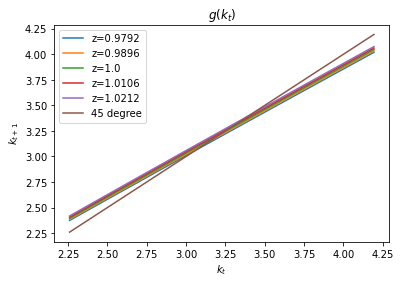

In [8]:
for i in range (5):
    plt.plot(kgrid,g[:,i],label='z='+ str(zgrid[i]))
plt.plot(kgrid,kgrid,label="45 degree")
plt.xlabel("$k_t$")
plt.ylabel("$k_{t+1}$")
plt.title('$g(k_t)$')
plt.legend()

## 计算资本稳定分布

## 计算联合分布的转移矩阵

In [9]:
P=np.array([[0.9727,0.0273,0,0,0],[0.0041,0.9806,0.0153,0,0],[0,0.0082,0.9836,0.0082,0],[0,0,0.0153,0.9806,0.0041],[0,0,0,0.0273,0.9727]])

In [10]:
def transQ(g):
    n_k, n_z = g.shape
    n = n_k * n_z
    Q = np.zeros((n, n))
    for j in numba.prange(n):
        i_k = j // n_z
        i_z = j % n_z
        diff = np.abs(g[i_k, i_z] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_z
        j_prime_end = j_prime_start + n_z
        Q[j, j_prime_start:j_prime_end] = P[i_z, :]
    return Q

In [11]:
Q=transQ(g)

In [12]:
Q.shape

(12500, 12500)

## 计算联合分布的不变分布

根据概率转移矩阵的性质，它的特征值的最大值为1，所以在数值求解过程中只需要获取矩阵的最大特征值对应的特征向量。为了保证稳健性，我这里计算了前五大特征值的特征向量。这样可以大大减少不必要的计算量

In [44]:
from scipy.sparse.linalg import eigs
# 计算最大的k个特征值和对应的特征向量
s = 5 # 调整为所需的特征值数量
eigenvalues, eigenvectors = eigs(Q.T, k=s, which='LM')  # 'LM'表示计算最大模特征值

In [45]:
index = np.argmin(np.abs(np.real(eigenvalues)-1.0))
stationary_vector = np.real(eigenvectors[:, index])
stationary_distribution = stationary_vector / np.sum(stationary_vector)

In [46]:
def capital_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_z))
    k_marginal = tmp.sum(axis=1)
    return k_marginal

In [47]:
k_marginal=capital_marginal(stationary_distribution)

In [48]:
np.min(k_marginal)

-5.658456412266739e-16

Text(0.5, 1.0, 'marginal distribution of k')

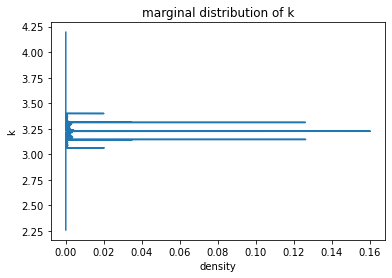

In [49]:
plt.plot(abs(k_marginal),kgrid)
plt.xlabel("density")
plt.ylabel("k")
plt.title('marginal distribution of k')
